# Final Project: Testing Visualizations

DS5001 Spring 2023 - Exploratory Text Analytics

Eve Schoenrock, UFU2RG

Contact: ufu2rg@virginia.edu

## Import and Set Up

In [1]:
import HarryPotterETA as hpe
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import plotly.express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
import seaborn as sns


OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [4]:
CORPUS = pd.read_csv('output/CORPUS.csv').set_index(OHCO)
LIB = pd.read_csv('output/LIB.csv').set_index('book_id')
POS = pd.read_csv('output-viz/POS.csv').set_index('pos_code')
POS_GROUP = pd.read_csv('output-viz/POS-GROUP.csv').set_index('pos_group')
PAIRS = pd.read_csv('output-viz/PAIRS.csv').set_index(['doc_a', 'doc_b'])
MT = pd.read_csv('output-viz/MT.csv').set_index('book_id')
DOCS = pd.read_csv('output-viz/DOCS.csv').set_index(['book_id', 'chap_num'])
DCM = pd.read_csv('output/PCA-DCM.csv').set_index(['book_id', 'chap_num'])
LOADINGS = pd.read_csv('output/PCA-LOADINGS.csv').set_index('term_str')
VOCAB = pd.read_csv('output/VOCAB.csv').set_index('term_str')

## Word Dispersion Plots

In [7]:
D = pd.get_dummies(CORPUS.term_str)

def word_plot(term_str):
    D[term_str].plot(figsize=(10, .5), legend=False, title=term_str.upper());

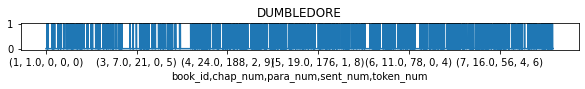

In [8]:
word_plot('dumbledore') # from M01_04_Further_Exploration

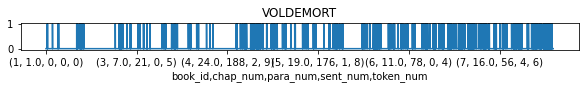

In [9]:
word_plot('voldemort')

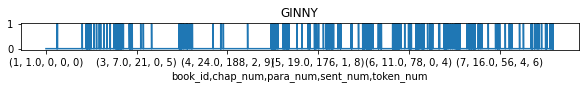

In [10]:
word_plot('ginny')

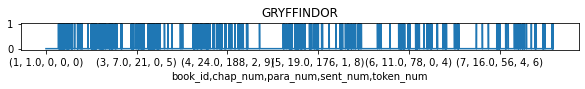

In [11]:
word_plot('gryffindor')

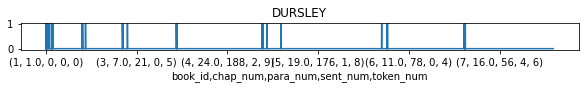

In [13]:
word_plot('dursley')

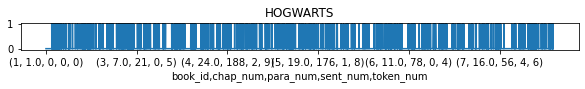

In [46]:
word_plot('hogwarts')

## Correlation Plots

In [14]:
CORR = CORPUS[['term_str']].reset_index()
CORR.set_index('token_num')[['term_str']]

term_str
token_num          
0                mr
1               and
2               mrs
3           dursley
5                of
...             ...
7          nineteen
8             years
0               all
1               was
2              well

[1118267 rows x 1 columns]

In [15]:
CORR['centile'] = (CORR.index * 100 / len(CORR)).astype('int') + 1

M = [None, None]
M[0] = CORR.groupby(['centile','term_str']).term_str.count().unstack(fill_value=0)
M[1] = M[0] / M[0].sum()

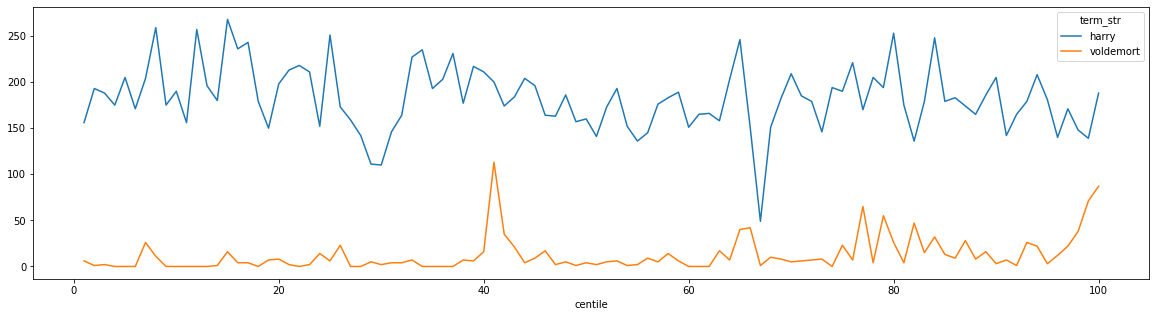

In [16]:
M[0][['harry','voldemort']].plot(figsize=(20,5), style='-');

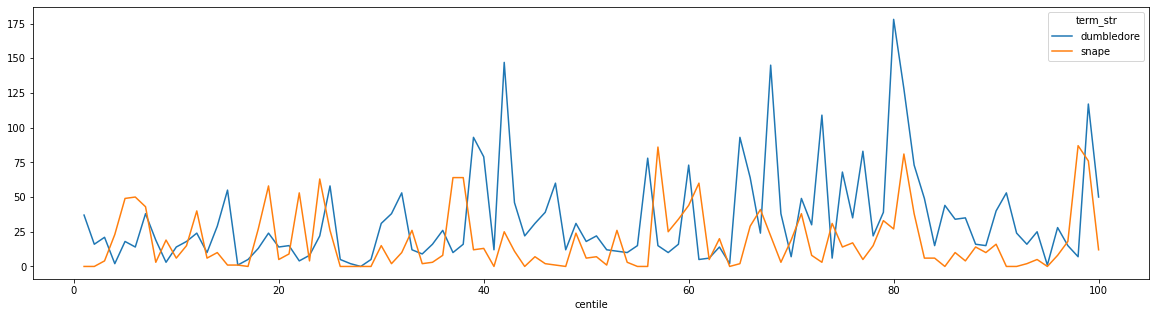

In [17]:
M[0][['dumbledore','snape']].plot(figsize=(20,5), style='-');

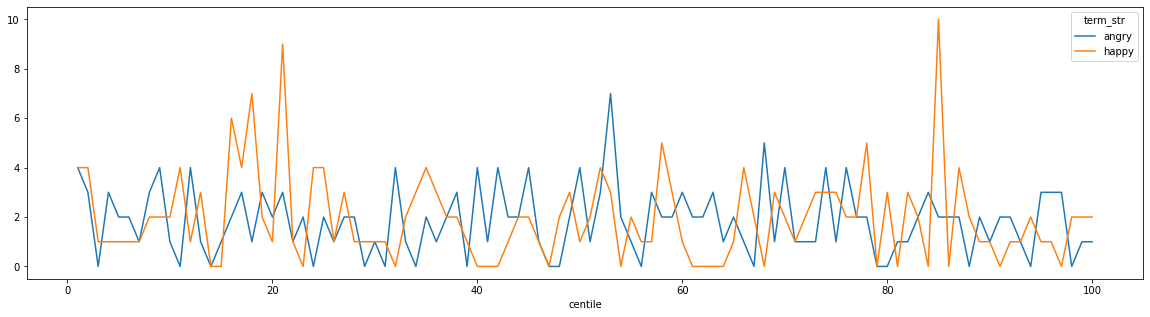

In [18]:
M[0][['angry','happy']].plot(figsize=(20,5), style='-');

## POS Illustration

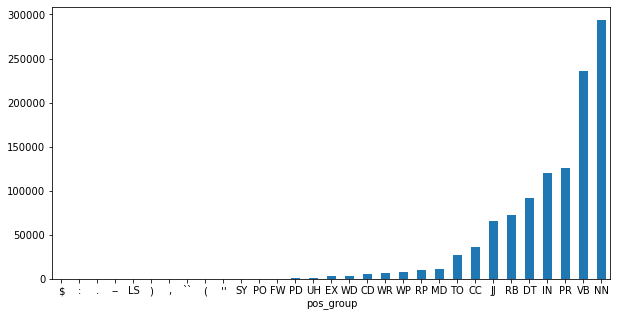

In [19]:
POS.groupby('pos_group').n.sum().sort_values().plot.bar(figsize=(10,5), rot=0);

In [20]:
def plot_pos():
    X = POS_GROUP[['n_terms','n_tokens', 'pos_def']].dropna().sort_values('n_terms')
    labels = X['pos_def']
    Y = X[['n_terms', 'n_tokens']]
    Z = ((Y - Y.mean(numeric_only=True)) / Y.std(numeric_only=True))
    return px.bar(Z, height=600, hover_name=labels, title="Comparison of Z-scores for POS token and term counts")

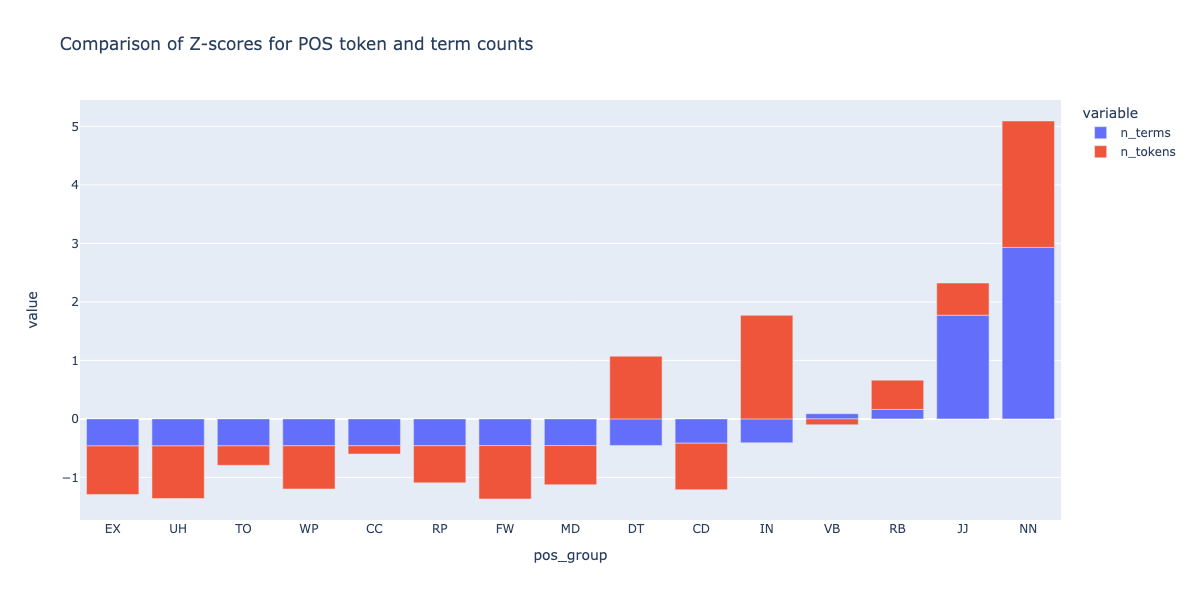

In [21]:
plot_pos()

## Correlation Dendograms

<Figure size 432x288 with 0 Axes>

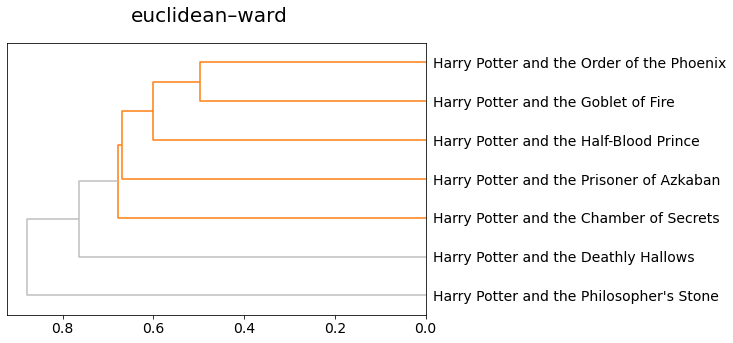

<Figure size 432x288 with 0 Axes>

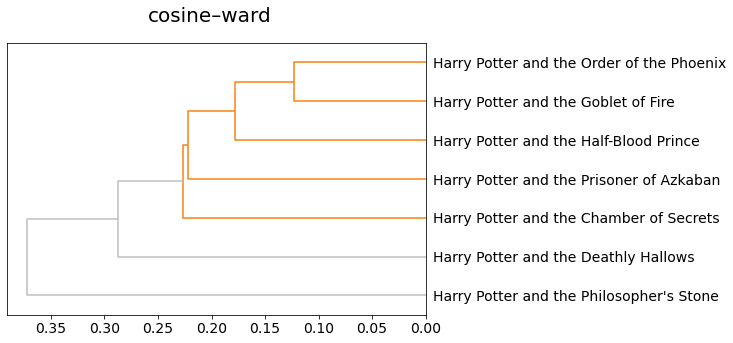

<Figure size 432x288 with 0 Axes>

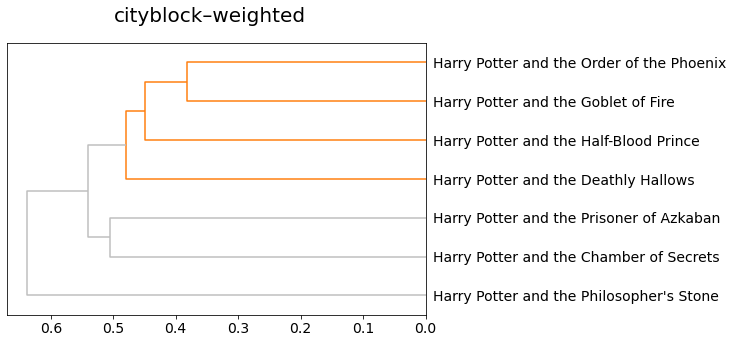

<Figure size 432x288 with 0 Axes>

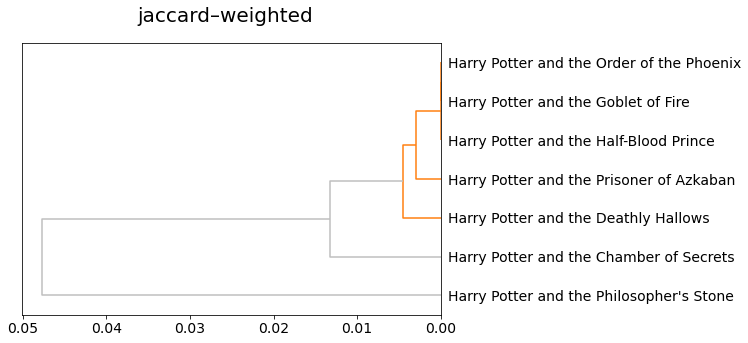

<Figure size 432x288 with 0 Axes>

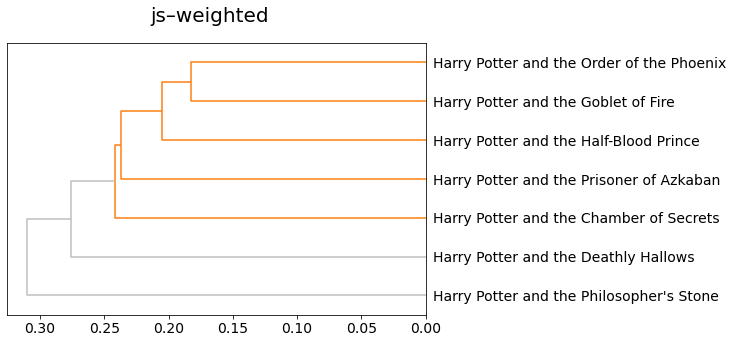

In [22]:
# Define function

L0 = MT.astype('bool').astype('int') # Binary (Pseudo L)
L1 = MT.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = MT.apply(lambda x: x / norm(x), 1) # Euclidean

general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median

combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (MT,  'cosine', 'cosine', euclidean_method),
    (MT,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.title.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{title}–{linkage_method}", fontsize=20)

for X, metric, title, linkage in combos:
    draw_hca(PAIRS[title], linkage_method=linkage)

## Compare Correlations with Kendall Sum

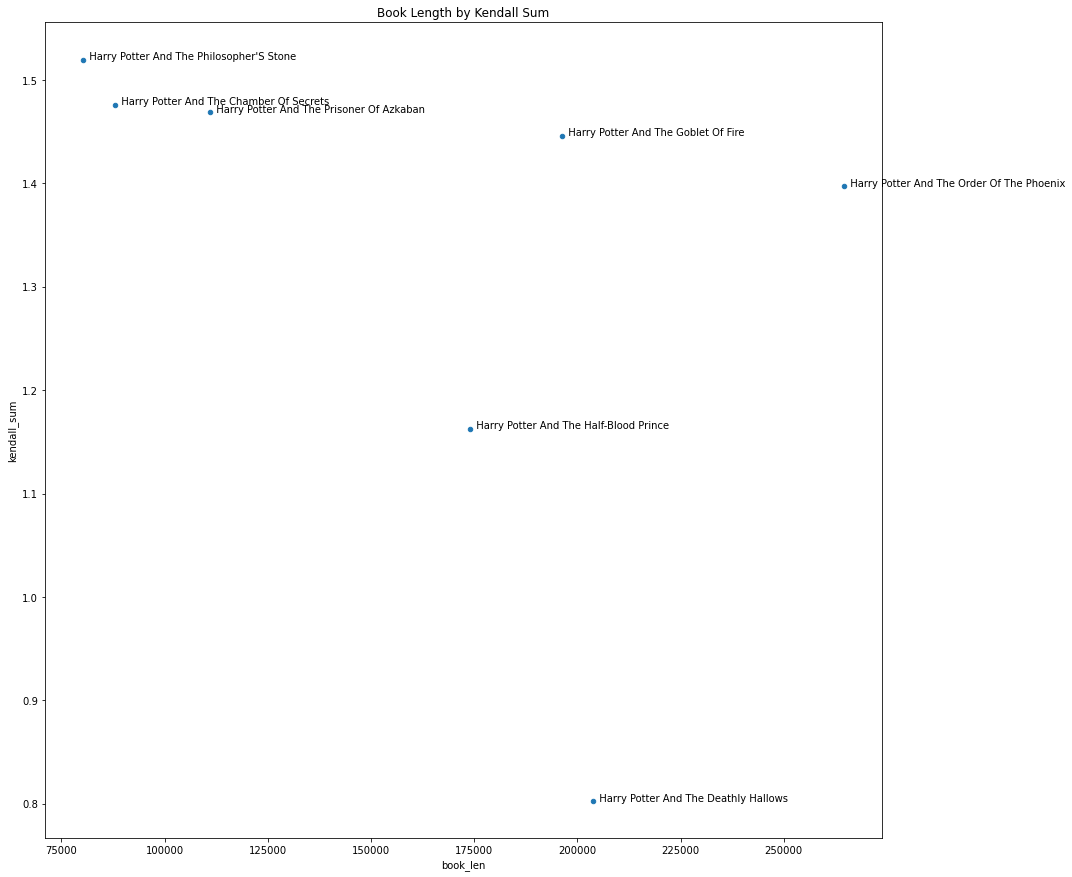

In [23]:
ax = LIB.plot.scatter('book_len', 'kendall_sum', figsize=(15,15), title="Book Length by Kendall Sum")
LIB.apply(lambda row: ax.text(row.book_len, row.kendall_sum, f"  {row.title.title()}"), axis=1);

## Strip Plots to Compare Multiple Word Frequencies

In [24]:
BOOK1 = hpe.get_book_from_corpus(CORPUS, 1)
BOOK2 = hpe.get_book_from_corpus(CORPUS, 2)
BOOK3 = hpe.get_book_from_corpus(CORPUS, 3)
BOOK4 = hpe.get_book_from_corpus(CORPUS, 4)
BOOK5 = hpe.get_book_from_corpus(CORPUS, 5)
BOOK6 = hpe.get_book_from_corpus(CORPUS, 6)
BOOK7 = hpe.get_book_from_corpus(CORPUS, 7)

In [25]:
B1 = BOOK1['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B2 = BOOK2['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B3 = BOOK3['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B4 = BOOK4['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B5 = BOOK5['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B6 = BOOK6['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B7 = BOOK7['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})

In [26]:
def plot_words(words, book, num):    
    
    X = book[book.term_str.isin(words)]
    
    plt.figure(figsize=(22, len(words)))
    
    ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
    ax.set_title('Dispersion Plots Book ' + str(num), size=30, pad=20)
    ax.set_xlabel('Narrative Time', size=20)
    ax.set_ylabel('Term', size=20)
    
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.tight_layout()
    plt.show()

In [27]:
names = 'ron hermione harry ginny'.split()

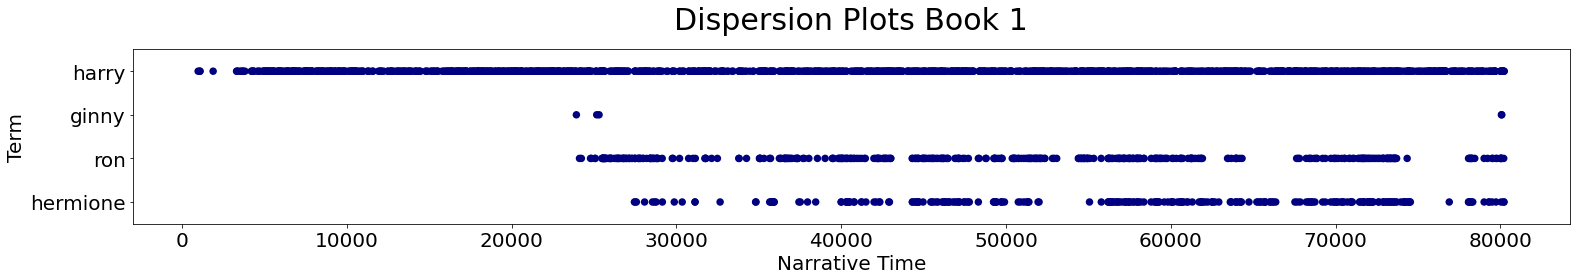

In [28]:
plot_words(names, B1, 1)

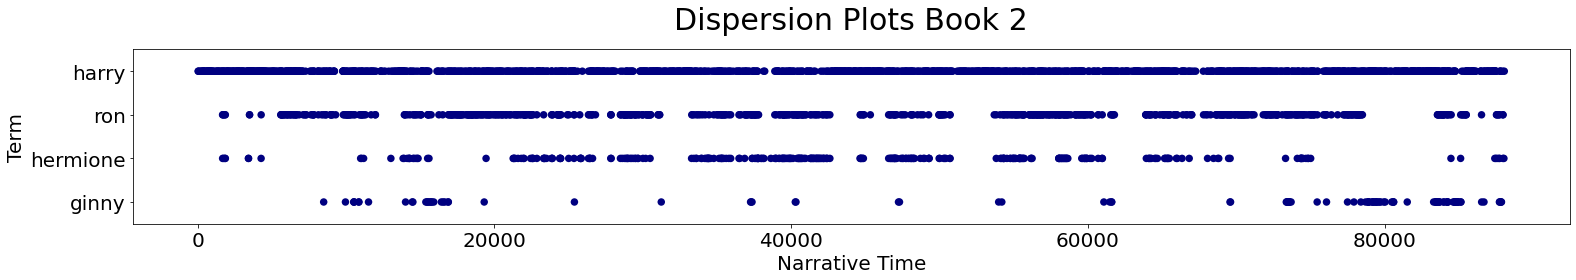

In [29]:
plot_words(names, B2, 2)

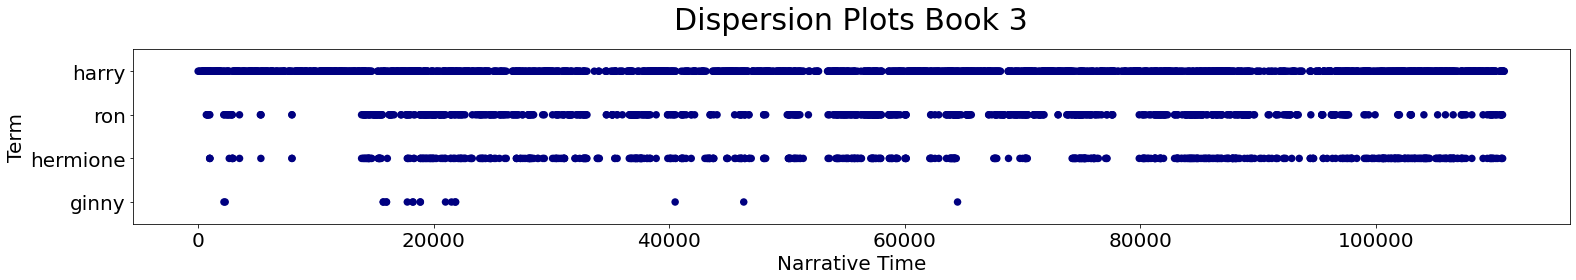

In [30]:
plot_words(names, B3, 3)

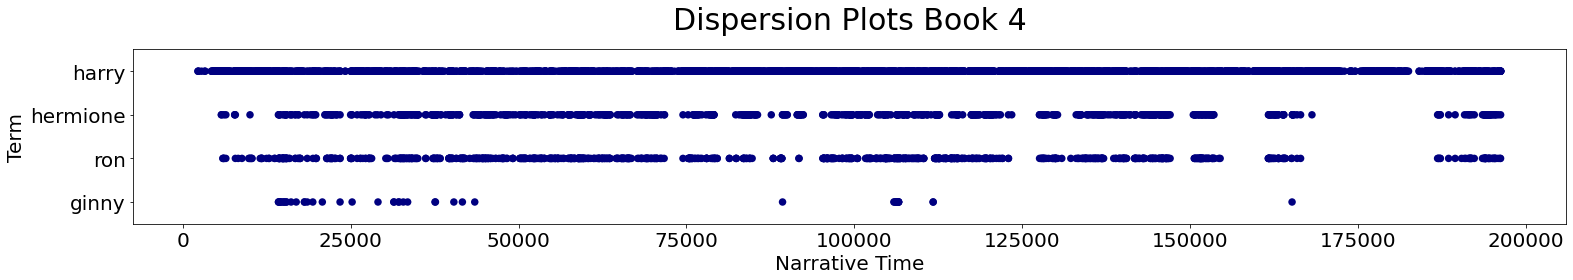

In [31]:
plot_words(names, B4, 4)

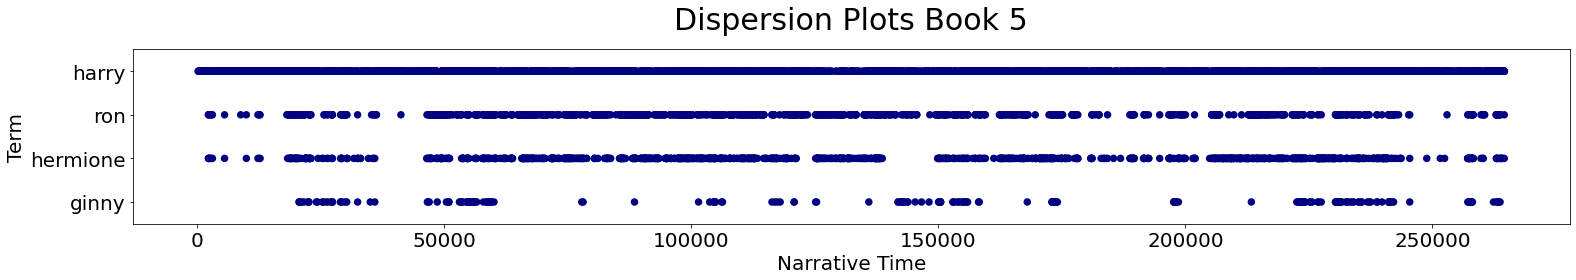

In [32]:
plot_words(names, B5, 5)

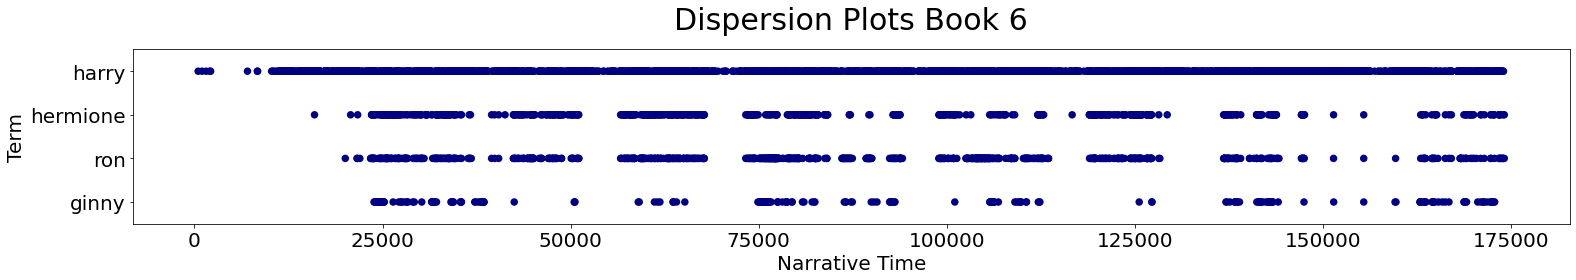

In [33]:
plot_words(names, B6, 6)

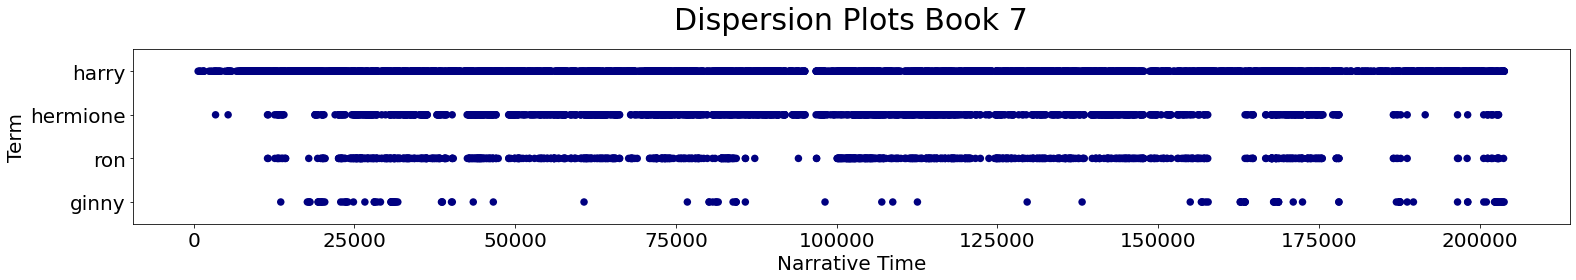

In [34]:
plot_words(names, B7, 7)

See that Hermione is more commonly referred to in book 7 than Ron!

## Plot Chapter Significance

### Function to Plot Chapter Significance, `plot_sig_docs`

In [35]:
def plot_sig_docs(book_id, type='scatter'):

    global DOCS
    D = DOCS.loc[book_id]
    title = LIB.loc[book_id].title
    point_size = (D.n / D.n.sum()) * 700
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=D.index, y=D.book_chap_sig, 
                             text=D.index, 
                             mode = 'lines+markers+text',
                             marker = dict(size=point_size, color='#BBB'),
                             line = dict(color='#DADADA'),
                             textfont = dict(color="black")
                            ))
                  
    fig.update_layout(
        font = dict(color="#000", size=14),
        title=title,
        xaxis_title="Chapter",
        yaxis_title="Significance",
        height=800
    )
    fig.show()

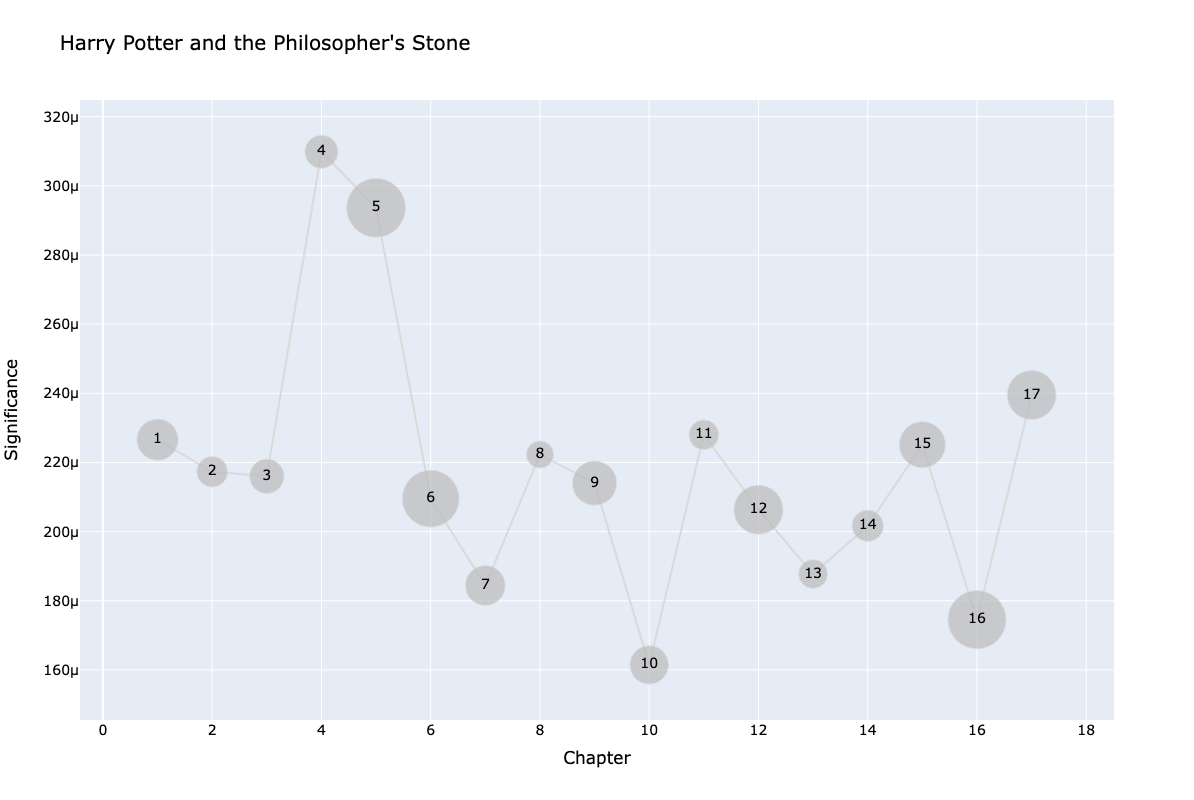

In [36]:
plot_sig_docs(1)

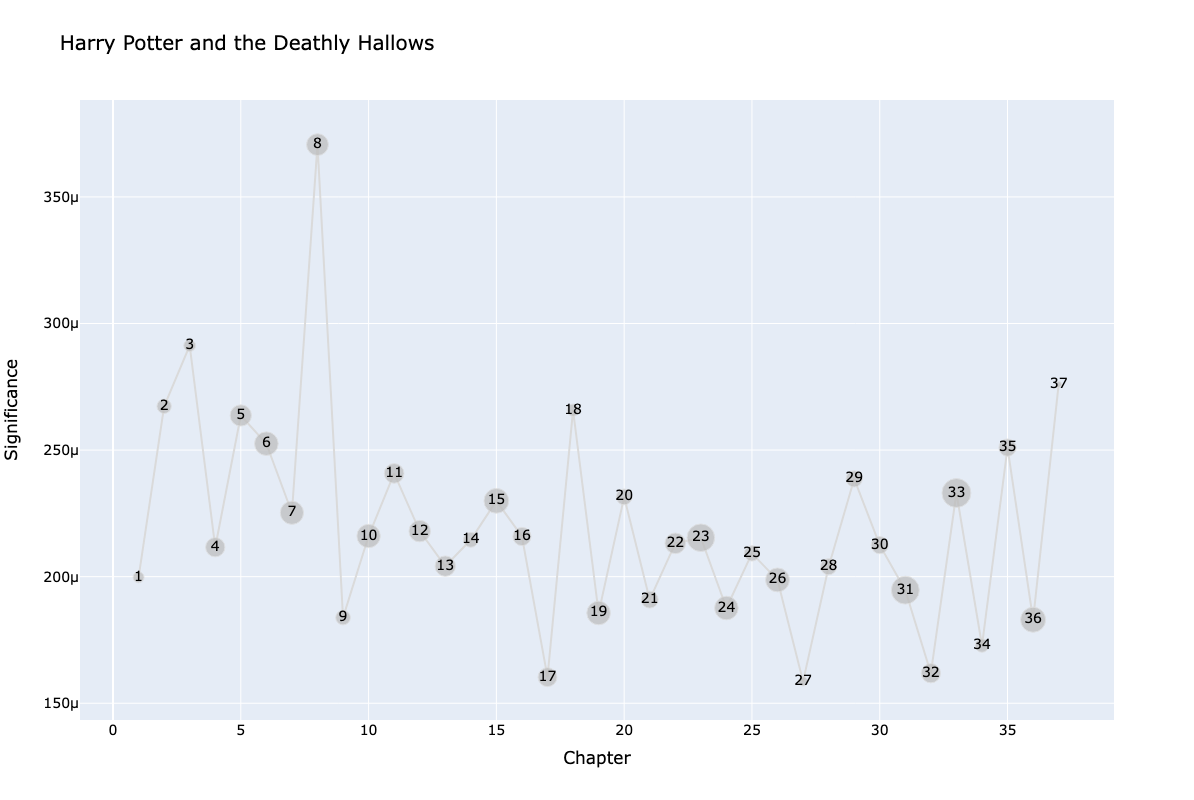

In [37]:
plot_sig_docs(7)

## PCA Visualizations

In [38]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos',
                      marginal_x='box', height=800)

In [39]:
def vis_pcs(M, a, b, label='title', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

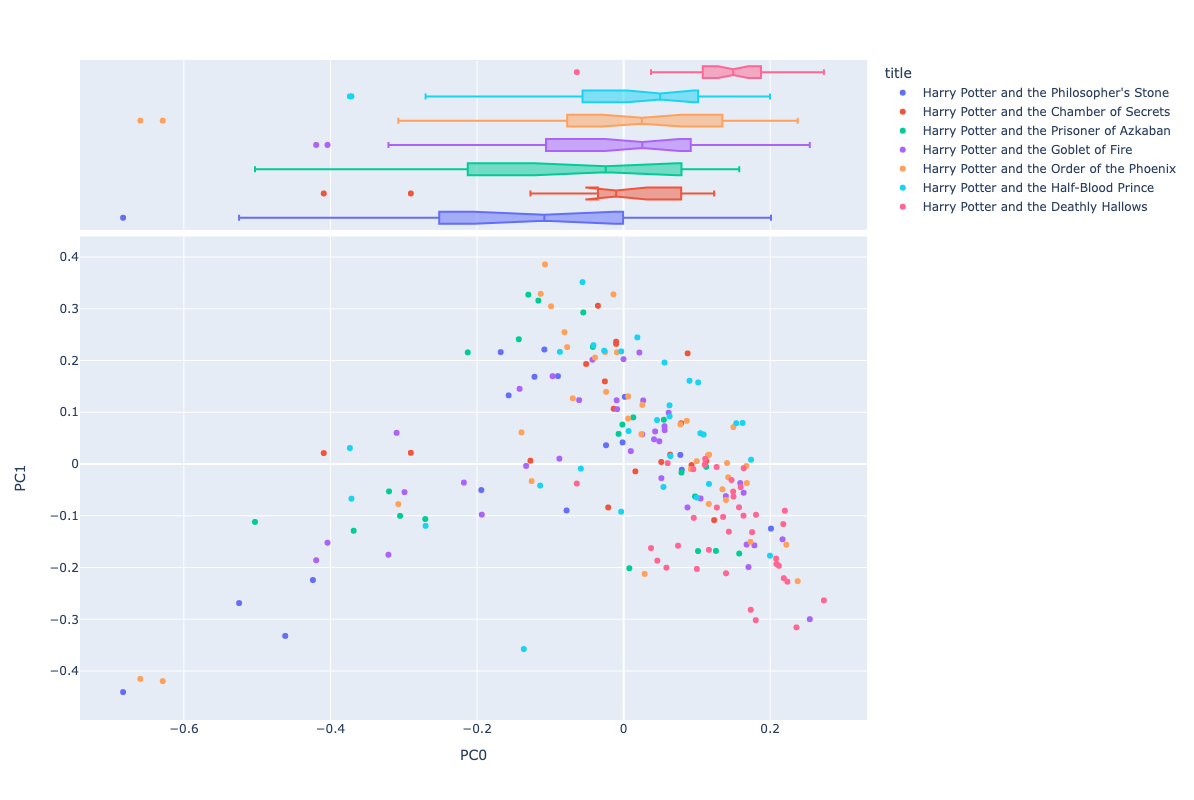

In [40]:
vis_pcs(DCM, 0, 1)

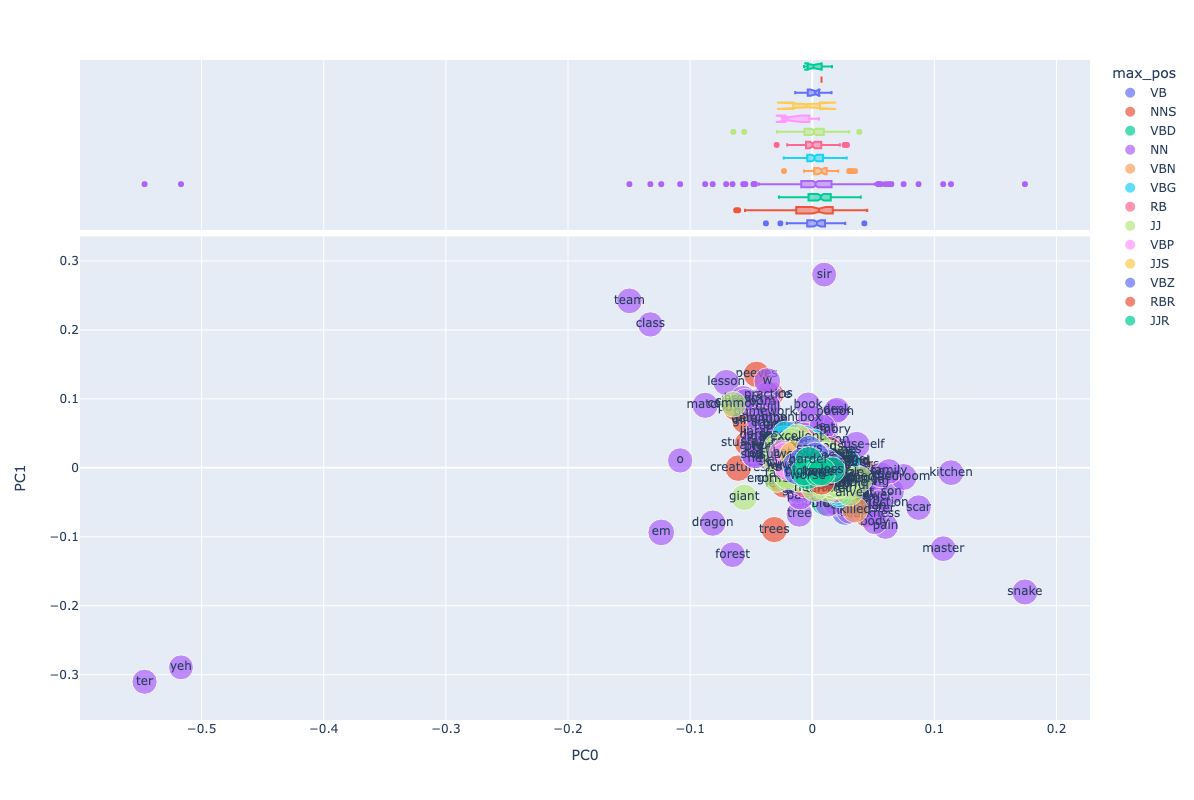

In [41]:
vis_loadings(0, 1)

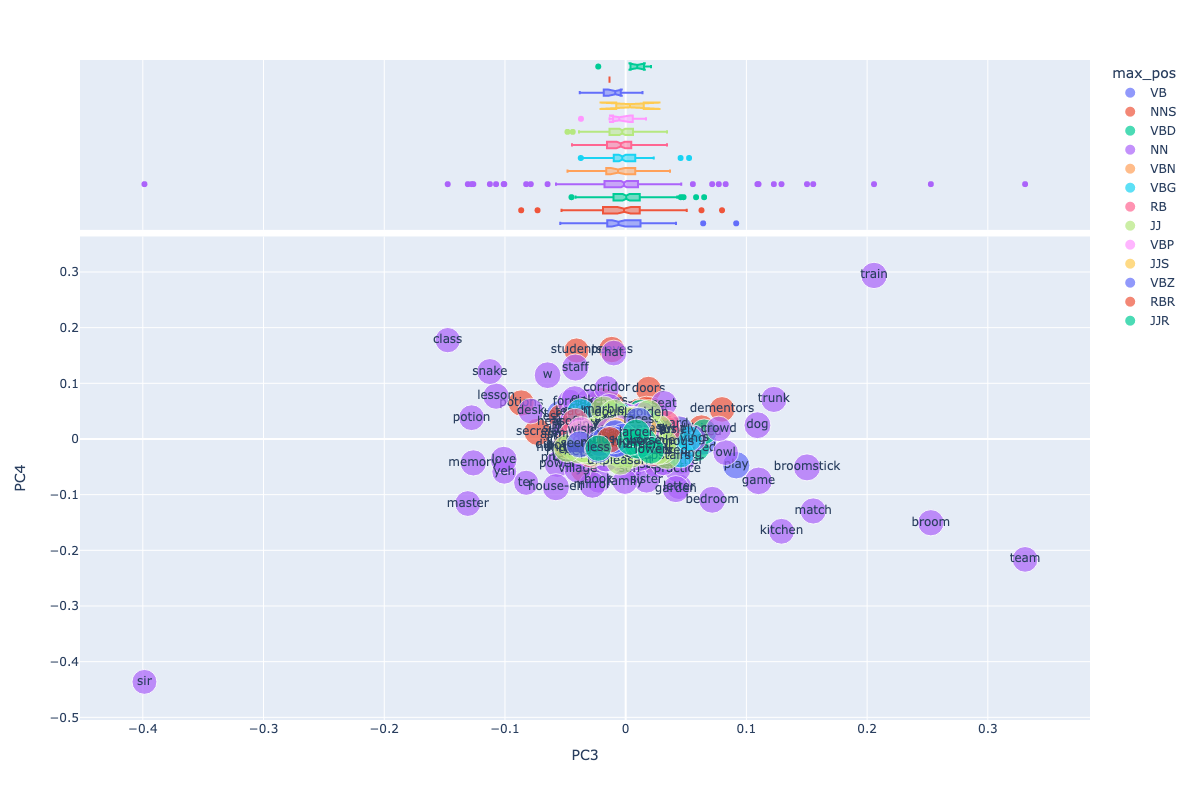

In [42]:
vis_loadings(3, 4) # the w as a word below comes from instances of a character saying "W - what?"

In [43]:
# to export as html run following code in terminal: jupyter nbconvert FINAL_REPORT.ipynb --no-input --to html